Here, I calculate empirical frequencies of goals converted during penalty shootouts to estimate conditional likelihoods of success for both scoring and winning the match.



In [1]:
# dependencies
library(dplyr) # to summarise data
library(tidyr) # to recast data
library(purrr) # for mapping to dataframes
library(forcats) # for manipulating factors
library(ggplot2) # for plotting
library(ggjoy) # for density plots
library(ggExtra) # for marginal histograms
library(scales) # for plotting opacity


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggjoy’ was built under R version 4.0.2”
Loading required package: ggridges

The ggjoy package has been deprecated. Please switch over to the
ggridges package, which provides the same functionality. Porting
guidelines can be found here:
https://github.com/clauswilke/ggjoy/blob/master/README.md

Warning message:
“package ‘ggExtra’ was built under R version 4.0.5”

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard




In [2]:
# read in data
pk<-read.csv("../00_data/02_processed/pks.csv",header=T)

# set data types
pk$match<-as.factor(pk$match)
pk$take_first <- as.factor(pk$take_first)
pk$sudden_death <- as.factor(pk$sudden_death)
pk$could_win <- as.factor(pk$could_win)
pk$must_survive <- as.factor(pk$must_survive)
pk$match_winner <- as.factor(pk$match_winner)
pk$neutral_stadium <- as.factor(pk$neutral_stadium)
pk$attacker_home <- as.factor(pk$attacker_home)

In [3]:
head(pk)

,shot,match,tournament,round,date,attacker_team,gk_team,attacker,goalkeeper,goal,⋯,sudden_death,could_win,must_survive,running_score,running_dif,match_winner,neutral_stadium,attacker_home,game_data,additional
,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>,<chr>
1,0,1,WC,semi,8-Jul-1982,France,Germany,Alain Giresse,Toni Schumacher,1,⋯,0,0,0,0,0,0,1,0,https://www.transfermarkt.us/spielbericht/index/spielbericht/965882,
2,1,1,WC,semi,8-Jul-1982,France,Germany,Manuel Amoros,Toni Schumacher,1,⋯,0,0,0,1,0,0,1,0,https://www.transfermarkt.us/spielbericht/index/spielbericht/965882,
3,2,1,WC,semi,8-Jul-1982,France,Germany,Dominique Rocheteau,Toni Schumacher,1,⋯,0,0,0,2,0,0,1,0,https://www.transfermarkt.us/spielbericht/index/spielbericht/965882,
4,3,1,WC,semi,8-Jul-1982,France,Germany,Didier Six,Toni Schumacher,0,⋯,0,0,0,3,1,0,1,0,https://www.transfermarkt.us/spielbericht/index/spielbericht/965882,
5,4,1,WC,semi,8-Jul-1982,France,Germany,Michel Platini,Toni Schumacher,1,⋯,0,0,0,3,0,0,1,0,https://www.transfermarkt.us/spielbericht/index/spielbericht/965882,
6,5,1,WC,semi,8-Jul-1982,France,Germany,Maxime Bossis,Toni Schumacher,0,⋯,1,0,0,4,0,0,1,0,https://www.transfermarkt.us/spielbericht/index/spielbericht/965882,


First, let's look at how long shootouts actually tend to last. They can last as few as three rounds, but there's also no upper limit to how long they could go. What is the distribution of shootout duration in historical matches?


  1   2   3   4   5   6   7   8   9  10  11  12  13 
600 600 600 575 368 137  76  58  32  14  14   6   4 

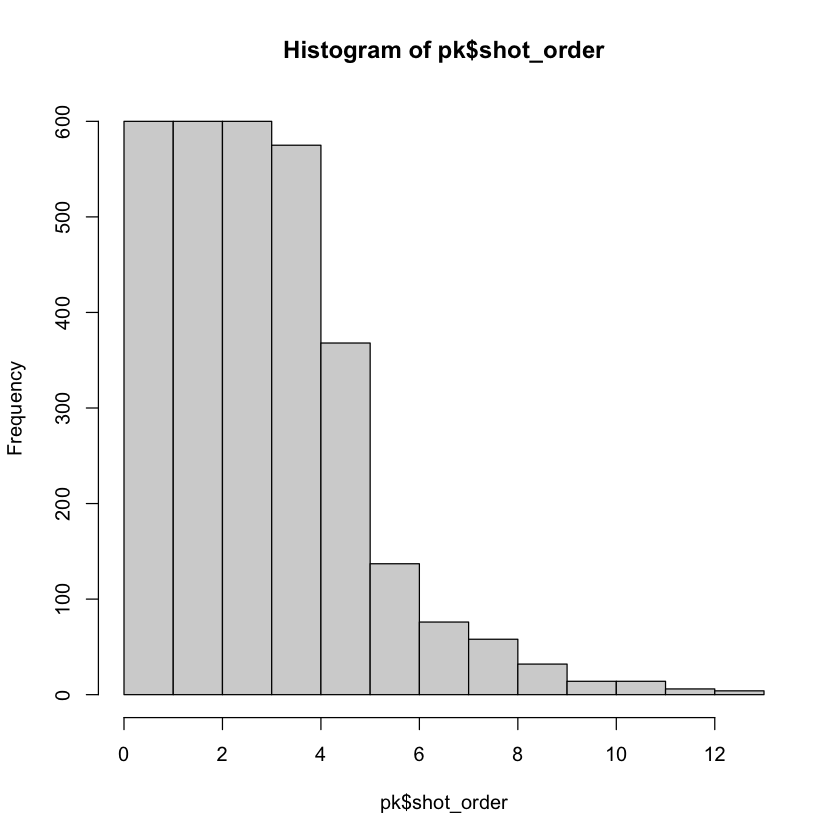

In [4]:
# check shot frequencies
table(pk$shot_order)
hist(pk$shot_order,breaks=seq.int(0,(max(pk$shot_order))))

Not many shootouts last beyond the 9th round. We'll focus analyses on the first 9 rounds

In [5]:
# keep only first nine rounds
pk <- pk[pk$shot_order<=9,]

# now with the desired # of rounds selected, set shot_order as a factor
pk$shot_order <- as.factor(pk$shot_order)

# and subset the data by team (take_order)
team_1 <- pk[pk$take_first==1,]
team_2 <- pk[pk$take_first==0,]


If we'd like to model penalty shots, we need to know if one model is appropriate for all shots. If shots are independent of one another (e.g., the outcome of shot 1 doesn't impact the outcome of shot 2) then one general model for all shots should suffice. 

So, are shots actually independent? This can be answered using a chi-squared test

In [6]:
# a function to test for independence based on conditional likelihoods:
# returns a contingency table of empirical frequencies and 
# the results of a chi-squared test of independence

shot_conds <- function(team1, # the team that takes the first shot of interest (1 or 2)
                       shot1, # the shot order of the first shot of interest (1-9)
                       team2, # the team that takes the second shot of interest (potentially conditional on shot1)
                       shot2) # the shot order of the second shot of interest (potentially conditional on shot1)
{
  
  # empty list to hold function output
  output <- list()
  
  # create vectors of shot conversion for each shot of interest from all matches in the dataset
  if (team1 == 1){
    shot_1 <- team_1 %>% group_by(match) %>% summarise(goal[shot1])
    shot_2 <- team_2 %>% group_by(match) %>% summarise(goal[shot2])
  } else if (team1 == 2){
    shot_1 <- team_2 %>% group_by(match) %>% summarise(goal[shot1]) 
    shot_2 <- team_1 %>% group_by(match) %>% summarise(goal[shot2]) 
  }
  
  # save to and return a dataframe
  shots <- data.frame(shot_1 = shot_1$`goal[shot1]`, shot_2 = shot_2$`goal[shot2]`)
  output$shot_table <- shots
  
  # return contingency tables of shot frequencies
  shot_counts <- table(shots)
  shot_freqs <- shot_counts/sum(shot_counts)
  output$shot_counts <- shot_counts
  output$shot_freqs <- shot_freqs
  
  # return chi-squared test results
  output$chisq_results <- chisq.test(shots$shot_1, shots$shot_2)
  
  invisible(output)
}

In [7]:
# does team 1's first shot influence team 2's first shot?
t1s1_t2s1 <- shot_conds(1,1,2,1); t1s1_t2s1$chisq_results$p.value # no

# does team 2's first shot influence team 1's second shot?
t2s1_t1s2 <- shot_conds(2,1,1,2); t2s1_t1s2$chisq_results$p.value # no

# does team 1's first shot influence team 1's second shot?
t1s1_t1s2 <- shot_conds(1,1,1,2); t1s1_t1s2$chisq_results$p.value # no

# does team 2's first shot influence team 2's second shot?
t2s1_t2s2 <- shot_conds(2,1,2,2); t2s1_t2s2$chisq_results$p.value # no

# does team 1's second shot influence team 2's second shot?
t1s2_t2s2 <- shot_conds(1,2,2,2); t1s2_t2s2$chisq_results$p.value # no

# does team 2's second shot influence team 1's third shot?
t2s2_t1s3 <- shot_conds(2,2,1,3); t2s2_t1s3$chisq_results$p.value # no

[1] 0.6222366

[1] 1

[1] 0.09279277

[1] 1

[1] 0.254574

[1] 0.1887518

It seems safe to say that consecutive shots are independent - the outcome of one shot does not influence the next attacker's chances of scoring the subsequent shot.

So let's start calculating likelihoods

### Likelihood estimation

Let's use a binomial distribution to model shot success. We can think of a penalty shot as a Bernouli trial with probability of success *p*, which follows a binomial distribution.

The likelihood is defined as the probability of the data given the model. Because penalty shots are independent trials, we can estimate the overall likelihood of the entire dataset by adding the log-likelihood values for each shot.

In [8]:
# function to calculate log likelihood of a dataset
log_likelihood <- function(par_p, par_N, data)
{
   logLik <- sum(dbinom(x = data, prob = par_p, size = par_N, log = T))
   return(logLik)
}

# sample of all penalty shots
all_shots <- pk$goal

# calculate the log likelihood of all shots
log_likelihood(par_p = 0.5, par_N = 1, data = all_shots)

[1] -2111.326

Now let's estimate the maximum likelihood of *p* (that is, what is the most likely probability of scoring a goal in a penalty shootout?). To do so we need to find the model that most likely generated this dataset. 

To derive the maximum likelihood estimate of p, we evaluate the likelihood function for a sequence of parameter values using a fine step size. Note that the maximum of the log-likelihood is identical to the maximum of the likelihood, because the log-function is a monotonously increasing function.

In [9]:
# vector of values for p
p_vec <- seq(0, 1, by = 0.01)

# vector of model log likelihoods
pk_logLik <- sapply(p_vec, FUN = log_likelihood, par_N = 1, data = all_shots)

# which model has tha maximum likelihood?
pk_max <- which.max(pk_logLik)
p_MLE <- p_vec[pk_max]

# maximum likelihood of the data
p_MLE

# compare to the empirical frequency of converted goals
mean(all_shots)

[1] 0.73

[1] 0.7298096

According to our model, there is a 73% likelihood of scoring a goal for a given shot in a penalty shootout. This is almost identical to the empirical frequency of converted goals: 72.98%

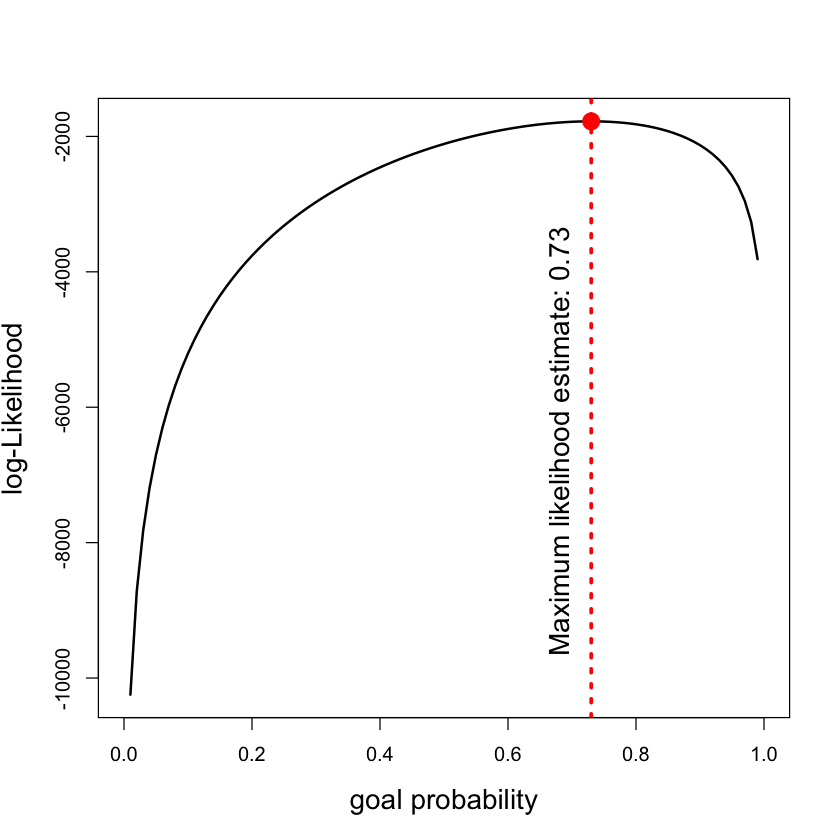

In [10]:
# plot likelihood estimates and MLE
plot(p_vec, pk_logLik, type = "l", lwd=2, xlab = "goal probability", ylab = "log-Likelihood", cex.lab=1.4)
abline(v=p_MLE, lty=3, col="red", lwd=3)
points(p_MLE, max(pk_logLik), pch=16, col="red", cex=2)
text(0.68, -6500, "Maximum likelihood estimate: 0.73", srt=90, cex=1.4)

But does shot probability differ between high-stakes and low-stakes scenarios?

In [11]:
sd_high <- pk[pk$sudden_death==1,]$goal
sd_low <- pk[pk$sudden_death!=1,]$goal
t.test(sd_high, sd_low)


	Welch Two Sample t-test

data:  sd_high and sd_low
t = -2.4689, df = 362.48, p-value = 0.01401
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.12596740 -0.01426835
sample estimates:
mean of x mean of y 
0.6666667 0.7367845 


In [12]:
cw_high <- pk[pk$could_win==1,]$goal
cw_low <- pk[pk$could_win!=1 & pk$must_survive!=1,]$goal
t.test(cw_high, cw_low)


	Welch Two Sample t-test

data:  cw_high and cw_low
t = 0.33394, df = 301.1, p-value = 0.7387
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04736022  0.06671888
sample estimates:
mean of x mean of y 
0.7469880 0.7373086 


In [13]:
ms_high <- pk[pk$must_survive==1,]$goal
ms_low <- pk[pk$must_survive!=1 & pk$could_win!=1,]$goal
t.test(ms_high, ms_low)


	Welch Two Sample t-test

data:  ms_high and ms_low
t = -2.8421, df = 385.47, p-value = 0.00472
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.13562348 -0.02470805
sample estimates:
mean of x mean of y 
0.6571429 0.7373086 


In [14]:
stakes <- list('sd_high' = sd_high, 'sd_low' = sd_low, 
               'cw_high' = cw_high, 'cw_low' = cw_low, 
               'ms_high' = ms_high, 'ms_low' = ms_low)

In [15]:
# extend the log_likelihood function to return maximum likelihood estimates
get_mle <- function(shots){
    
    # vector of possible goal probabilities
    p_vec <- seq(0, 1, by = 0.01)

    # vector of model log likelihoods
    logLik <- sapply(p_vec, FUN = log_likelihood, par_N = 1, data = shots)

    # maximum likelihood estimate
    p_MLE <- p_vec[which.max(logLik)]
    return(p_MLE)

}

# MLE's for different high/low stakes scenarios
lapply(stakes, get_mle)

$sd_high
[1] 0.67

$sd_low
[1] 0.74

$cw_high
[1] 0.75

$cw_low
[1] 0.74

$ms_high
[1] 0.66

$ms_low
[1] 0.74

According to our model:
- Sudden death shots are 7% less likely to be scored than best-of-five shots
- Could-win shots are equally likely to be scored as lower stakes shots
- Must-survive shots are 8% less likely to be scored than lower stakes shots